In [1]:
import numpy as np
import xarray as xr
import scipy.interpolate as intp
from xmitgcm import open_mdsdataset
import matplotlib.gridspec as gridspec
from matplotlib.colors import from_levels_and_colors as flc
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
res = 1e1 #km

# set output_directory to save input files. 
output_dir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'

# set format of binary files 
tp= '>f8'

In [3]:
# function that makes xy grid
def make_grid_xy(nx,ny, lengthx=1.0e6, lengthy=2.0e6):
    lx, ly = lengthx, lengthy
    # nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [4]:
# domain width and length (currently using a square)
Ly = 2.0e6
Lx = 1.0e6

# number of center grid points (how many dx fit in the domain)
nx = int(Lx/res/1000)
ny = int(Ly/res/1000)

# generate the x,y grid
xc, yc = make_grid_xy(nx,ny, Lx,Ly)

# Topographic shape
Large scale shape of topography - flat bottom with gaussian bump

$$ bathy = -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 2985$ m, $h_0 = 927$ m and $\sigma = 75$ km.
(The particular numbers are chosen to match Ryan's previous experiments, and also work with the vertical grid)

In [5]:
H  = 2985.0
h0 = 0.
sig= 75.0e3

bathy      = -(H - h0*np.exp(-(xc - Lx/2)**2 / sig**2))
bathy[:,:] = -H
bathy[0,:] = 0.0 # create a wall to the south. By default MITgcm assumes periodic in both directions.

In [6]:
bathy.astype(tp).tofile(output_dir + 'BATHY_flat_bump_deep%03dkm.bin' % res)

# Wind conditions
We use an atmospheric jet as the wind forcing. This condition diverges slightly from Ryan's previous runs, as generate a jet that is more focussed in the center (change from $sin(y)$ to $sin^2(y)$).

$$ \tau = \tau_0 sin^2(\pi y/L_y) $$

In order to add the binomial seasonality, we change the value of $\tau_0$.

In [5]:
# tau0 = 0.2
tau0 = xr.open_dataarray('zonal-windstress-amp_SOSE.nc')
tau0

<xarray.DataArray (month: 12)>
array([ 0.142106,  0.145191,  0.157315,  0.15643 ,  0.145289,  0.135237,
        0.135194,  0.145828,  0.158918,  0.161905,  0.147637,  0.129302])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [6]:
tau = np.zeros([ny,nx])

# make sure that the wind goes to zero at the north and south boundary within in the domain.
# be careful that one grid point to the south is just land. 
# the way the wind is defined right now, the wavelength changes slightly between runs.
# also make sure that the wind profile looks the same in all the runs with different resolution.

dy = yc[1,1] - yc[0,1]
tau = tau0.data[:,np.newaxis,np.newaxis]*(np.sin(np.pi* (yc)/(Ly))**2) # slightly squeezed wind profile to account 
# for the presence of land cell at the southern most grid cell.

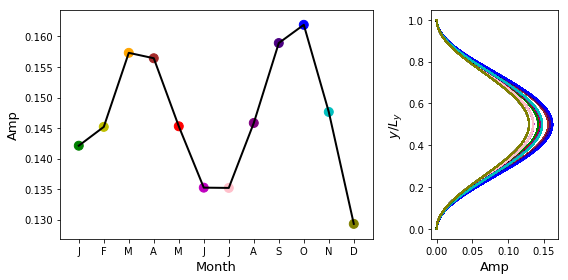

In [7]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(nrows=1,ncols=6)
ax1 = plt.subplot(gs[:,:4])
ax2 = plt.subplot(gs[:,4:])
ax1.plot(range(1,13),tau0, 'k', lw=2)
ax1.scatter(range(1,13),tau0,color=colors,s=80)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.set_xlabel('Month', fontsize=13)
ax1.set_ylabel('Amp', fontsize=13)
for i in range(12):
    ax2.plot(tau[i],yc/Ly,c=colors[i])
ax2.set_xlabel('Amp', fontsize=13)
ax2.set_ylabel(r'$y/L_y$', fontsize=13)
plt.tight_layout()
plt.savefig('SurfaceTau-sin2_seasonality_sinusoid.pdf')

In [8]:
tau.shape

(12, 200, 100)

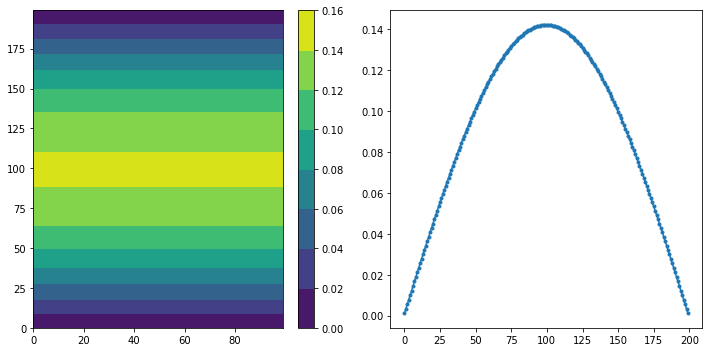

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(tau[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(tau[0,:,0],'.-')
plt.tight_layout()

In [9]:
tau.shape

(12, 200, 100)

In [10]:
tau.astype(tp).tofile((output_dir + 'TAU-sin2_seasonal_%03dkm.bin'%res))

# Surface buoyancy conditions
Restore the surface to a linear buoyancy profile (temperature as there is no salt in the simulation)

$$ T(y) = T_0 (y/L_y) $$

where $T_0$ is also changed to incorporate seasonality.

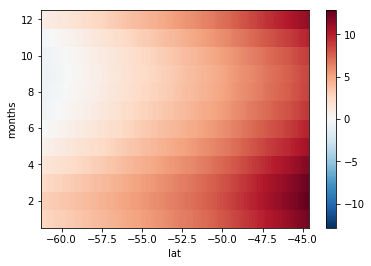

In [20]:
# Tmin, Tmax = 0., 8.0
Tvar = xr.open_dataarray('theta-surface-seasonality_SOSE.nc')
Tvar[:,20:].plot()

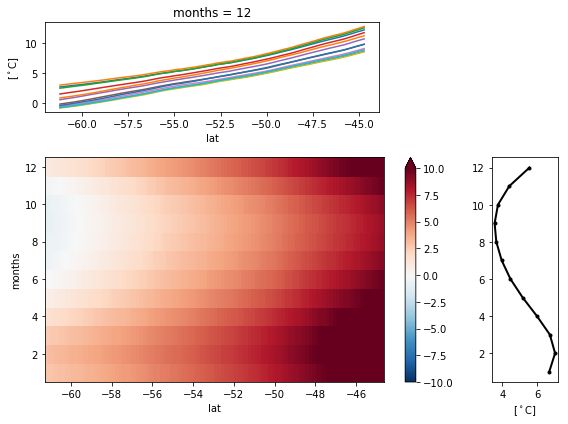

In [21]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    Tvar[i,20:].plot(ax=ax1)
ax1.set_ylabel(r'[$^\circ$C]')
Tvar[:,20:].plot(ax=ax2, vmax=1e1, rasterized=True)
ax3.plot(Tvar[:,20:].mean('lat'),Tvar.months, 'k.-', lw=2)
ax3.set_xlabel(r'[$^\circ$C]')
plt.tight_layout()
plt.savefig('SurfaceTempRelax_seasonality.pdf')

In [23]:
Tvar

<xarray.DataArray (months: 12, lat: 120)>
array([[  1.579012,   1.664284,   1.741423, ...,  11.961906,  12.099498,
         12.263033],
       [  1.909737,   1.977846,   2.042606, ...,  12.504911,  12.654976,
         12.834866],
       [  1.167639,   1.249033,   1.329446, ...,  12.265095,  12.423638,
         12.60034 ],
       ..., 
       [ -1.62735 ,  -1.61947 ,  -1.607957, ...,   8.662838,   8.791461,
          8.922498],
       [ -1.521113,  -1.507431,  -1.485396, ...,   9.585423,   9.717598,
          9.86097 ],
       [ -0.649404,  -0.583058,  -0.509742, ...,  10.989108,  11.124984,
         11.282024]])
Coordinates:
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -64.54 -64.37 -64.21 -64.04 -63.87 -63.71 -63.54 ...

In [25]:
# Tmin, Tmax = 0., 8.0
# Tsurf = (Tmax-Tmin)*yc/Ly

Tsurf = np.zeros((12,200,100))
for i in range(12):
    f = intp.interp1d(np.arange(100), Tvar[i,20:].data, fill_value='extrapolate')
    Tsurf[i] = f(np.arange(0,100,.5))[:,np.newaxis] * np.ones(100)

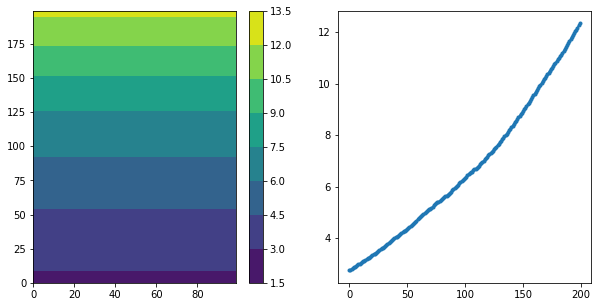

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[0,:,0],'.-')

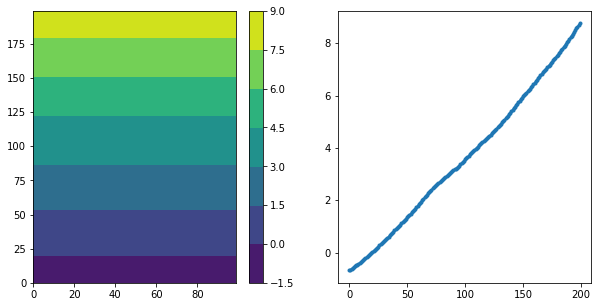

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf[7])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[7,:,0],'.-')

In [29]:
Tsurf.astype(tp).tofile((output_dir + 'THETA_surf_SOSE_%03dkm.bin' %res))

# PAR condition

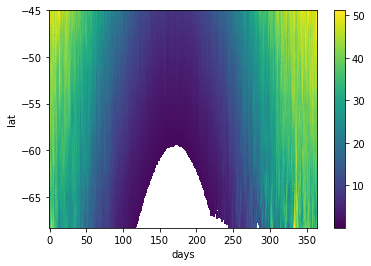

In [59]:
PARvar = xr.open_dataarray('PAR_45-65_SeaWiFS.nc')
PARvar[:,20:].plot(x='days',y='lat')

In [8]:
PARvar

<xarray.DataArray (days: 365, lat: 300)>
[109500 values with dtype=float64]
Coordinates:
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lat      (lat) float64 -43.38 -43.46 -43.54 -43.63 -43.71 -43.79 -43.88 ...

In [62]:
PAR_mon = np.zeros((12,300))
mon_days = {'Jan':range(31),'Feb':range(31,59),'Mar':range(59,90),'Apr':range(90,120),'May':range(120,151),
           'Jun':range(151,181),'Jul':range(181,212),'Aug':range(212,243),'Sep':range(243,273),'Oct':range(273,304),
           'Nov':range(304,334),'Dec':range(334,365)}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
i = 0
for month in months:
    PAR_mon[i] = np.nanmean(PARvar[mon_days[month][0]:mon_days[month][-1]], axis=0)
    i += 1

PAR_mon = xr.DataArray(PAR_mon, dims=['month','lat'],
                       coords={'month':range(1,13), 'lat':PARvar.lat.data}
                      )

/rigel/home/tu2140/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


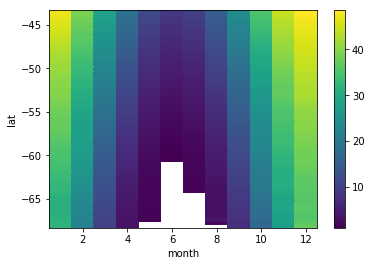

In [63]:
PAR_mon.plot(x='month',y='lat')

In [64]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [65]:
for i in range(12):
    nans, x = nan_helper(PAR_mon[i].data)
    PAR_mon[i,nans] = np.interp(x(nans), x(~nans), PAR_mon.data[i,~nans])

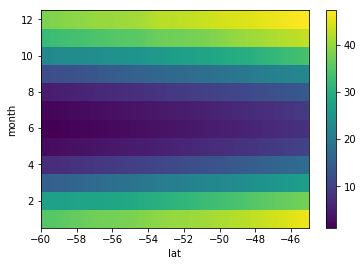

In [66]:
PAR_mon.sel(lat=slice(-45.,-60.)).plot()

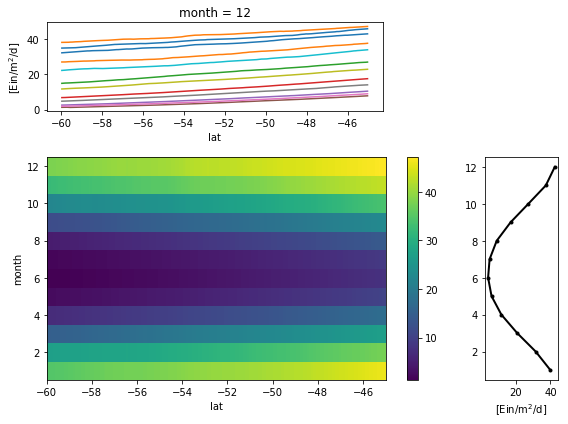

In [72]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    PAR_mon.sel(lat=slice(-45.,-60.))[i].plot(ax=ax1)
ax1.set_ylabel(r'[Ein/m$^2$/d]')
PAR_mon.sel(lat=slice(-45.,-60.)).plot(ax=ax2, rasterized=True)
ax3.plot(PAR_mon.sel(lat=slice(-45.,-60.)).mean('lat'), 
         Tvar.months, 'k.-', lw=2)
ax3.set_xlabel(r'[Ein/m$^2$/d]')
plt.tight_layout()
plt.savefig('PAR_seasonality.pdf')

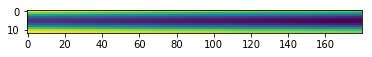

In [35]:
plt.imshow(PAR_mon.sel(lat=slice(-45.,-60.)).data)

In [32]:
PAR_mon.sel(lat=slice(-45.,-60.))

<xarray.DataArray (month: 12, lat: 180)>
array([[ 45.898347,  45.831076,  45.714652, ...,  34.999574,  34.988059,
         34.935979],
       [ 37.667248,  37.550736,  37.483492, ...,  27.049212,  27.063788,
         27.032973],
       [ 26.983407,  26.885225,  26.849725, ...,  15.0639  ,  14.984814,
         14.906311],
       ..., 
       [ 33.973304,  33.909159,  33.834854, ...,  22.394544,  22.318544,
         22.241424],
       [ 43.021811,  42.967677,  42.865669, ...,  32.375318,  32.304694,
         32.244368],
       [ 47.22691 ,  47.165099,  47.131571, ...,  38.217194,  38.206489,
         38.170315]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -45.04 -45.13 -45.21 -45.29 -45.38 -45.46 -45.54 ...

In [37]:
PAR = np.zeros((12,200,100))
for i in range(12):
    f = intp.interp1d(np.arange(180), np.flipud(PAR_mon.sel(lat=slice(-45.,-60.))[i].data), fill_value='extrapolate')
    PAR[i] = f(np.arange(0,180,180*5e-3))[:,np.newaxis] * np.ones(100)

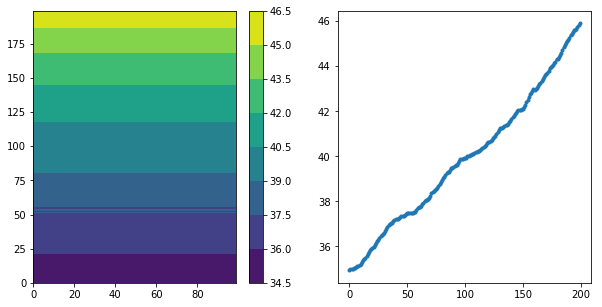

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(PAR[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(PAR[0,:,0],'.-')

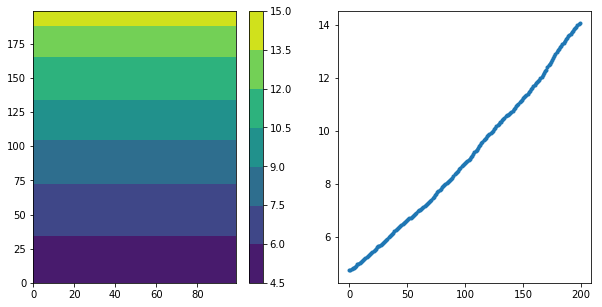

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(PAR[7])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(PAR[7,:,0],'.-')

In [41]:
PAR.astype(tp).tofile(output_dir + 'PAR_SeaWiFS_%03dkm.bin' %res)

# Interpolate the initial conditions on stratification
Currently just using the ones from the old runs by Ryan. However the exact intial condition shouldn't be significant.

In [7]:
zaxis = np.array([   -5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,
                -102. ,  -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,
                -393. ,  -471.5,  -565. ,  -667.5,  -770.5,  -873.5,  -976.5,
               -1079.5, -1182.5, -1285.5, -1388.5, -1491.5, -1594.5, -1697.5,
               -1800.5, -1903.5, -2006.5, -2109.5, -2212.5, -2315.5, -2418.5,
               -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])

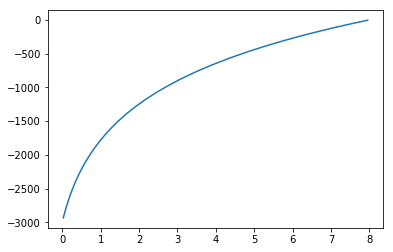

In [8]:
delT = 8.0 
h = 1000. 
Hmax = 2985.0

# Use expression (2) from Abernathey et al 2011
Tstar = delT*(np.exp(zaxis/h) - np.exp(-Hmax/h))/(1-  np.exp(-Hmax/h))

#plt.plot(temp_relax_large[:,200,0] , zaxis)
plt.plot(Tstar, zaxis) 
# There is slight difference from the profile in the paper. 
# so we will use the analytical expression

In [5]:
# temp_relax_large_analytical = np.tile(Tstar, (100,200,1)).T
# temp_relax_large_analytical.shape
temp_relax = xr.open_dataarray('theta-north-seasonality_SOSE.nc')
temp_relax

<xarray.DataArray (months: 12, depth: 40)>
array([[ 12.263032,  12.159218,  11.931634, ...,   1.631734,   1.552415,
          1.472886],
       [ 12.834866,  12.740322,  12.552646, ...,   1.633206,   1.553829,
          1.474417],
       [ 12.60034 ,  12.561832,  12.490166, ...,   1.637308,   1.558122,
          1.478771],
       ..., 
       [  8.922498,   8.884137,   8.837459, ...,   1.6343  ,   1.555805,
          1.477103],
       [  9.86097 ,   9.774057,   9.650754, ...,   1.635744,   1.557572,
          1.479146],
       [ 11.282024,  11.1414  ,  10.860046, ...,   1.634382,   1.556341,
          1.478163]])
Coordinates:
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth    (depth) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

In [82]:
temp_relax.T

<xarray.DataArray (depth: 40, months: 12)>
array([[ 12.263032,  12.834866,  12.60034 , ...,   8.922498,   9.86097 ,
         11.282024],
       [ 12.159218,  12.740322,  12.561832, ...,   8.884137,   9.774057,
         11.1414  ],
       [ 11.931634,  12.552646,  12.490166, ...,   8.837459,   9.650754,
         10.860046],
       ..., 
       [  1.631734,   1.633206,   1.637308, ...,   1.6343  ,   1.635744,
          1.634382],
       [  1.552415,   1.553829,   1.558122, ...,   1.555805,   1.557572,
          1.556341],
       [  1.472886,   1.474417,   1.478771, ...,   1.477103,   1.479146,
          1.478163]])
Coordinates:
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth    (depth) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

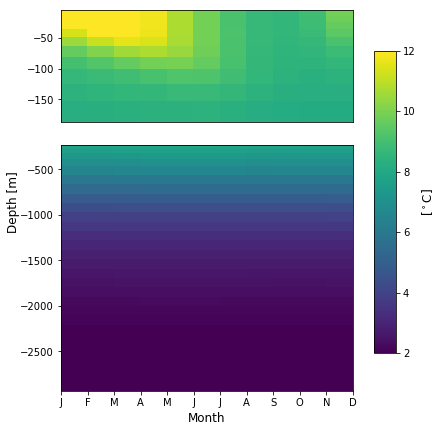

In [19]:
nz = 11
fig = plt.figure(figsize=(6,7))
gs = gridspec.GridSpec(ncols=1, nrows=3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1:,0])
cax = ax1.pcolormesh(range(12), temp_relax.depth[:nz], temp_relax.T[:nz,:], 
                     vmin=2, vmax=12, rasterized=True)
ax2.pcolormesh(range(12), temp_relax.depth[nz:], temp_relax.T[nz:,:], 
               vmin=2, vmax=12, rasterized=True)
ax1.set_xticks([])
ax2.set_xticks(range(12))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax2.set_xlabel('Month', fontsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r'[$^\circ$C]',fontsize=12)
fig.text(0, 0.5, 'Depth [m]', 
         va='center', rotation='vertical', fontsize=12)
plt.savefig('NorthTempRelax_Seasonality.pdf')

In [6]:
temp_relax

<xarray.DataArray (months: 12, depth: 40)>
array([[ 12.263032,  12.159218,  11.931634, ...,   1.631734,   1.552415,
          1.472886],
       [ 12.834866,  12.740322,  12.552646, ...,   1.633206,   1.553829,
          1.474417],
       [ 12.60034 ,  12.561832,  12.490166, ...,   1.637308,   1.558122,
          1.478771],
       ..., 
       [  8.922498,   8.884137,   8.837459, ...,   1.6343  ,   1.555805,
          1.477103],
       [  9.86097 ,   9.774057,   9.650754, ...,   1.635744,   1.557572,
          1.479146],
       [ 11.282024,  11.1414  ,  10.860046, ...,   1.634382,   1.556341,
          1.478163]])
Coordinates:
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth    (depth) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

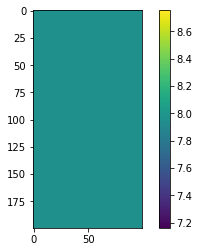

In [23]:
plt.imshow(temp_relax_large_analytical[0])
plt.colorbar()

In [32]:
(temp_relax.data[:,:,np.newaxis,np.newaxis]*np.ones((200,100))).astype(tp).tofile(output_dir 
                                                            + 'rbcs_temp-seasonal-relax_SOSE_%03dkm.bin' 
                                                            % res)

In [10]:
temp_init = temp_relax_large_analytical + np.random.randn(temp_relax_large_analytical.shape[0],
                                                         temp_relax_large_analytical.shape[1],
                                                         temp_relax_large_analytical.shape[2])

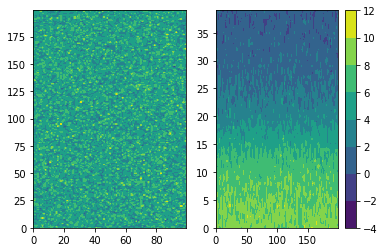

In [11]:
plt.figure()

plt.subplot(121)
plt.contourf(temp_init[0,:,:])

plt.subplot(122)
plt.contourf(temp_init[:,:,0])

plt.colorbar()

In [12]:
temp_init.astype(tp).tofile(output_dir + 'THETA_init_%03dkm_1.5C.bin' % res)

In [26]:
mask = np.zeros((200,100))
mask[-10:] += np.linspace(0.,1.,num=10)[:,np.newaxis] * np.ones((10,100))
rbcs_mask = np.tile(mask,(40,1,1))
rbcs_mask.shape

(40, 200, 100)

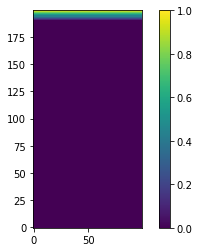

In [30]:
plt.imshow(rbcs_mask[-1], origin='bottom')
plt.colorbar()

In [31]:
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_temp_relax_mask_%03dkm.bin' % res)

In [7]:
2592*12

31104

In [ ]:
:q